In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ical_li import (li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)
from experiments.ical_mewes import mewes_act

In [5]:
modelfile = 'models/nygren_ical.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

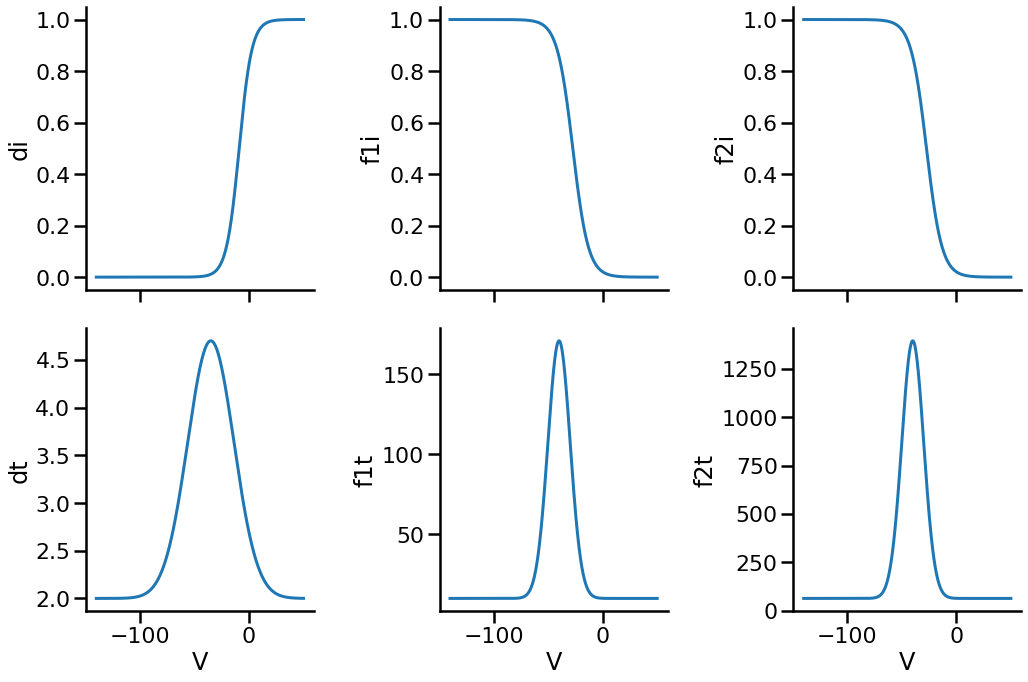

In [7]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

nyg_vars = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_vars, 'models/nygren_ical.mmt', figshape=(3,2))

# d gate -> Only activation data

In [15]:
observations, model, summary_statistics = setup(modelfile,
                                                mewes_act)

In [16]:
assert len(observations)==len(summary_statistics(model({})))

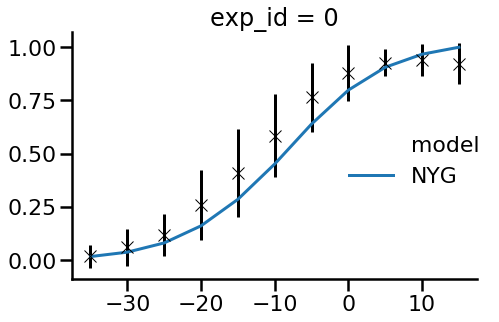

In [17]:
g = plot_sim_results(modelfile,
                     mewes_act)

In [35]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
          #'ical.q1': (0, 100),
          #'ical.q2': (0, 50),
          #'log_ical.q3': (-2, 0),
          #'ical.q4': (0, 100),
          #'ical.q5': (0, 50),
          #'log_ical.q6': (-3, -1),
          #'log_ical.r1': (-1, 1),
          #'ical.r2': (0, 100),
          #'ical.r3': (0, 100),
          #'log_ical.r4': (-3, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [36]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_reported.db"))

In [37]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [38]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [39]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.8620971283223635, '1': 1.1636171131795543, '2': 1.0342944621090917, '3': 0.6205155126018103, '4': 0.48986542101291475, '5': 0.5170198235080876, '6': 0.6205155126018118, '7': 0.7756730599221309, '8': 1.5522067038604508, '9': 1.3299008007726998, '10': 1.0342944621090833}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [40]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [41]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-17 15:20:25.262537, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2021
DEBUG:Epsilon:new eps, t=1, eps=1.7467760870612525
INFO:ABC:t:1 eps:1.7467760870612525
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 6104
DEBUG:Epsilon:new eps, t=2, eps=0.8312431374514421
INFO:ABC:t:2 eps:0.8312431374514421
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 12091
DEBUG:Epsilon:new eps, t=3, eps=0.5116924090713459
INFO:ABC:t:3 eps:0.5116924090713459
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 20828
DEBUG:Epsilon:new eps, t=4, eps=0.39913435256168345
INFO:ABC:t:4 eps:0.39913435256168345
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 31083
DEBUG:Epsilon:new eps, t=5, eps=0.3835215

### Database results analysis

In [70]:
history = History(db_path)

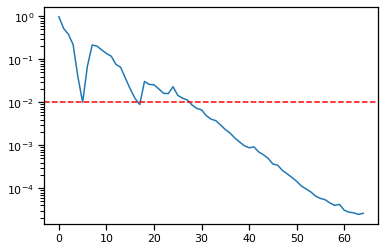

In [65]:
eps = history.get_all_populations()['epsilon'][1:].tolist()
change = []
for i in range(len(eps)-1):
    change.append(abs(eps[i+1]-eps[i])/eps[i])

plt.semilogy(change)
plt.axhline(y=0.01, linestyle='--', color='r')

converge_index = np.argwhere(np.asarray(change)<=0.01)[0][0]+1

In [71]:
df, w = history.get_distribution()

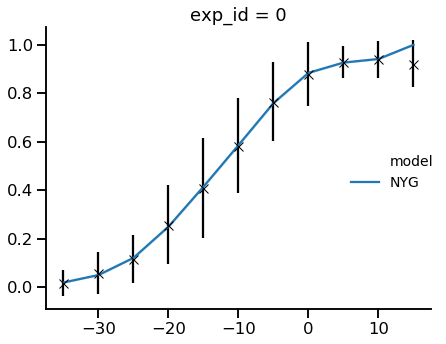

In [72]:
g = plot_sim_results(modelfile,
                     mewes_act,
                     df=df, w=w)

In [73]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

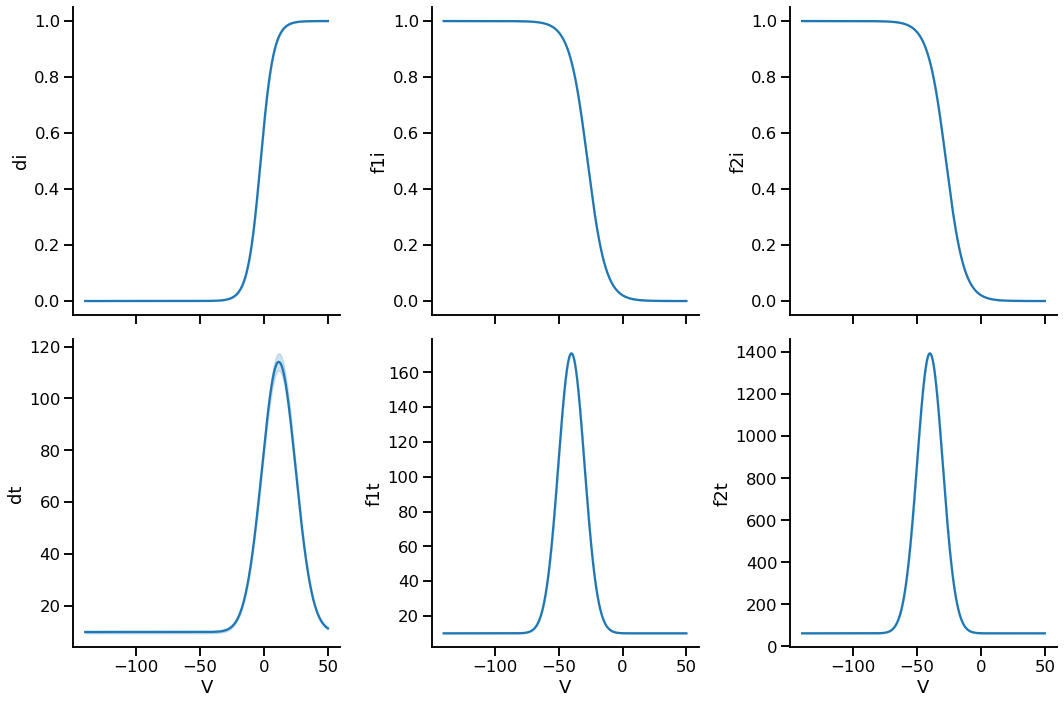

In [74]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_ical.mmt', 
                       [nyg_pars],
                       figshape=(3,2))

In [75]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [76]:
m,_,_ = myokit.load(modelfile)

In [77]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

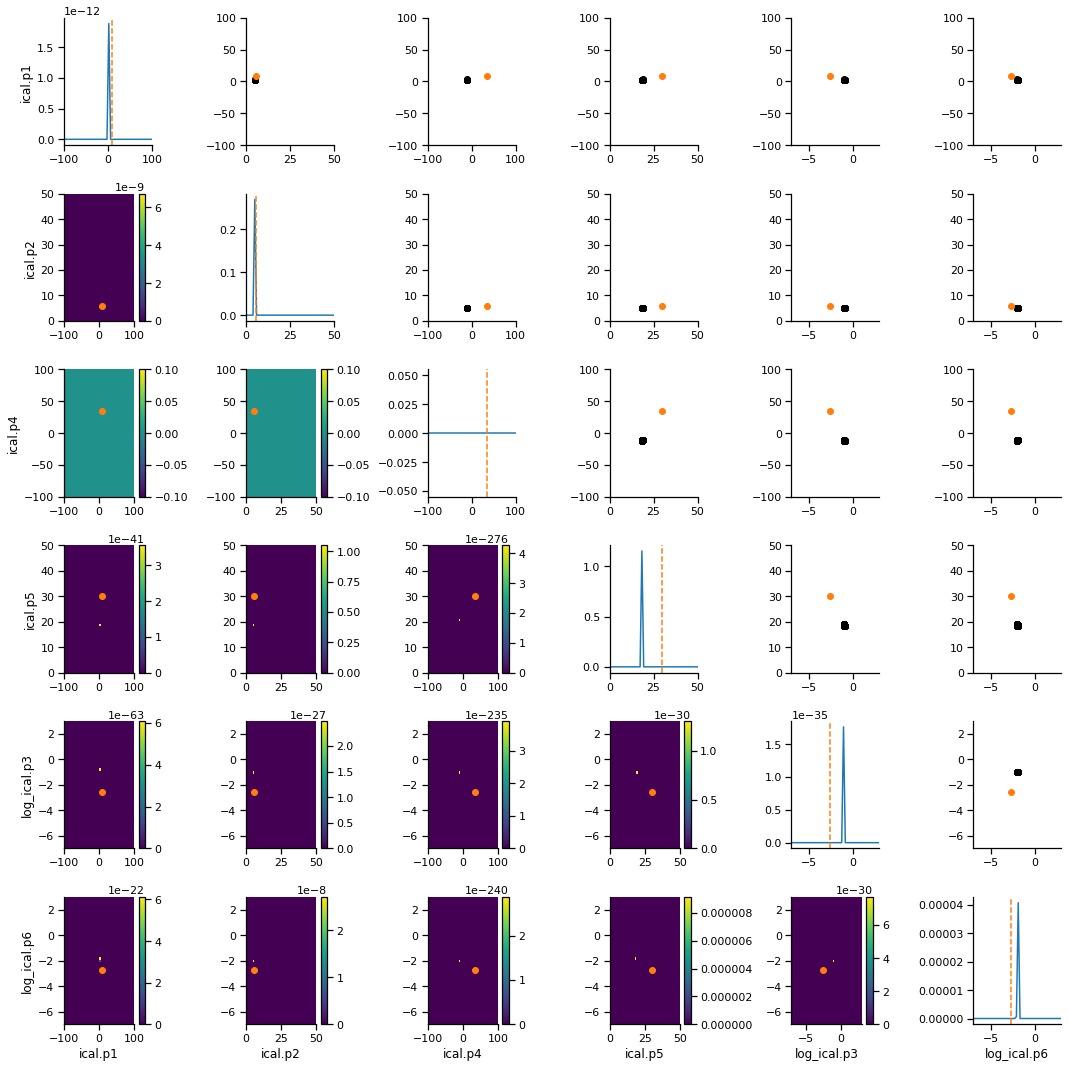

In [78]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# f gate -> Inactivation

In [79]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [80]:
assert len(observations)==len(summary_statistics(model({})))

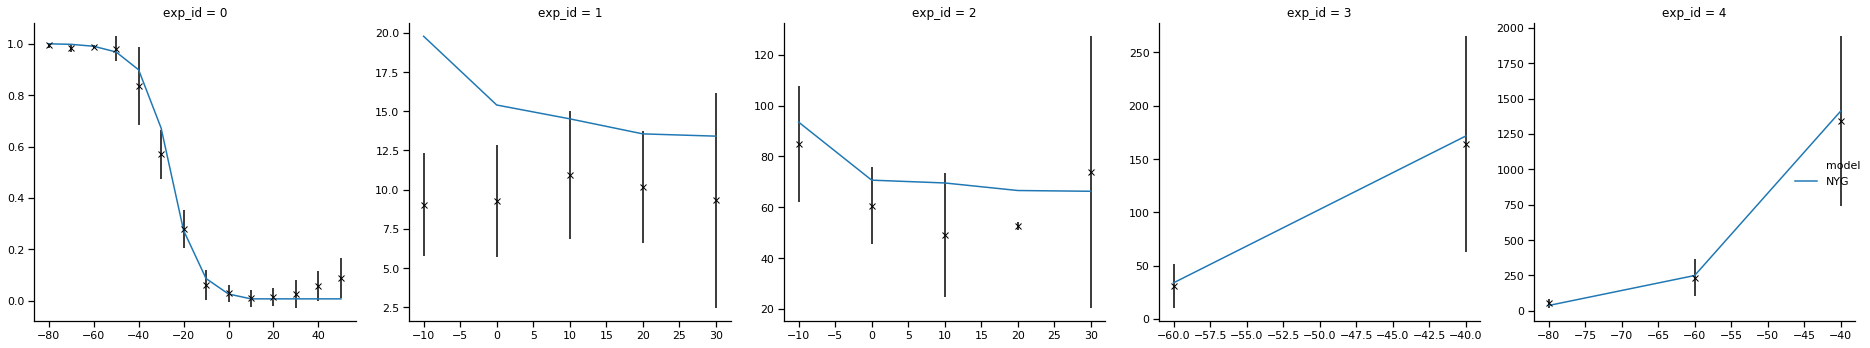

In [81]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [82]:
limits = {'ical.q1': (0, 100),
          'ical.q2': (0, 50),
          'log_ical.q3': (-7, 3),
          'ical.q4': (0, 100),
          'ical.q5': (0, 50),
          'log_ical.q6': (-7, 3),
          'log_ical.r1': (-7, 3),
          'ical.r2': (0, 100),
          'ical.r3': (0, 100),
          'log_ical.r4': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [83]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_fgates_reported.db"))

In [84]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [85]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [86]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810967, '1': 0.9837148289810967, '2': 0.9837148289810967, '3': 0.9837148289810967, '4': 0.3255918060516033, '5': 0.5055241199222262, '6': 0.6753486289586007, '7': 0.8392681990941822, '8': 0.9837148289810967, '9': 0.9837148289810967, '10': 0.9837148289810967, '11': 0.9196236649649016, '12': 0.8392681990941822, '13': 0.6309826606328519, '14': 0.4608478344438249, '15': 0.4184561967200059, '16': 0.36886776090803813, '17': 0.4191992497796024, '18': 0.21952975590454923, '19': 0.5102122707484874, '20': 0.7659862673065287, '21': 0.47913670089197835, '22': 2.754401521147071, '23': 0.21885528270246785, '24': 2.749064693405502, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.354305935366494, '28': 0.5128531003233773}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [87]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [88]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 19:52:53.526379, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [46]:
history = History(db_path)

In [47]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-10 13:12:53.052766, end_time=2019-10-10 23:38:39.207619)>]

In [48]:
df, w = history.get_distribution(m=0)

In [49]:
df.describe()

name,ical.E_Ca_app,ical.q1,ical.q2,ical.q4,ical.q5,ical.r2,ical.r3,log_ical.q3,log_ical.q6,log_ical.r1,log_ical.r4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,51.255075,28.658701,6.707021,49.015876,26.670306,42.308204,9.515817,-2.607732,-2.243454,-0.201745,-1.690089
std,25.461694,4.885781,2.915279,25.922446,12.754369,5.137879,3.308889,2.302561,2.112325,0.469343,0.038425
min,0.078299,16.713135,0.062101,0.021468,0.138126,26.469381,0.868885,-6.997205,-6.993081,-1.097918,-1.831431
25%,30.567921,25.326895,4.715504,27.601313,16.634251,39.104185,7.182332,-4.399195,-3.809284,-0.614029,-1.715051
50%,52.711778,28.073743,6.534390,48.410564,27.341359,42.332515,9.421776,-2.545918,-1.606677,-0.254996,-1.690403
75%,71.449991,31.223470,8.561245,69.982150,36.539044,45.183978,11.666178,-0.870557,-0.895609,0.149140,-1.664897
max,99.997901,49.450203,17.508028,99.907173,49.963157,60.703015,22.420806,2.996533,2.979215,2.860360,-1.569164


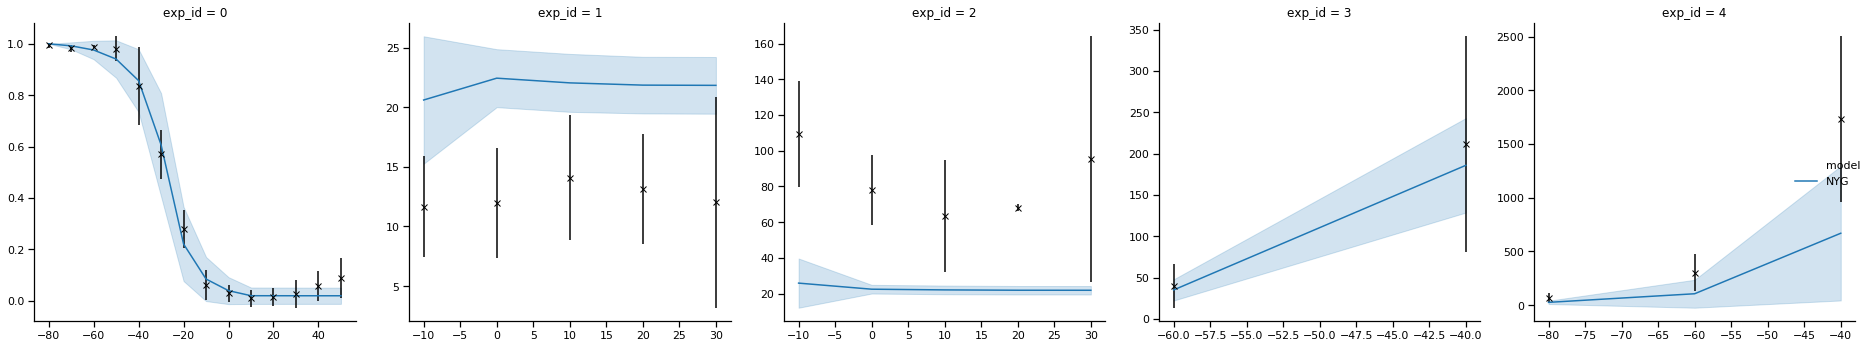

In [50]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

In [51]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [52]:
m,_,_ = myokit.load(modelfile)

In [53]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

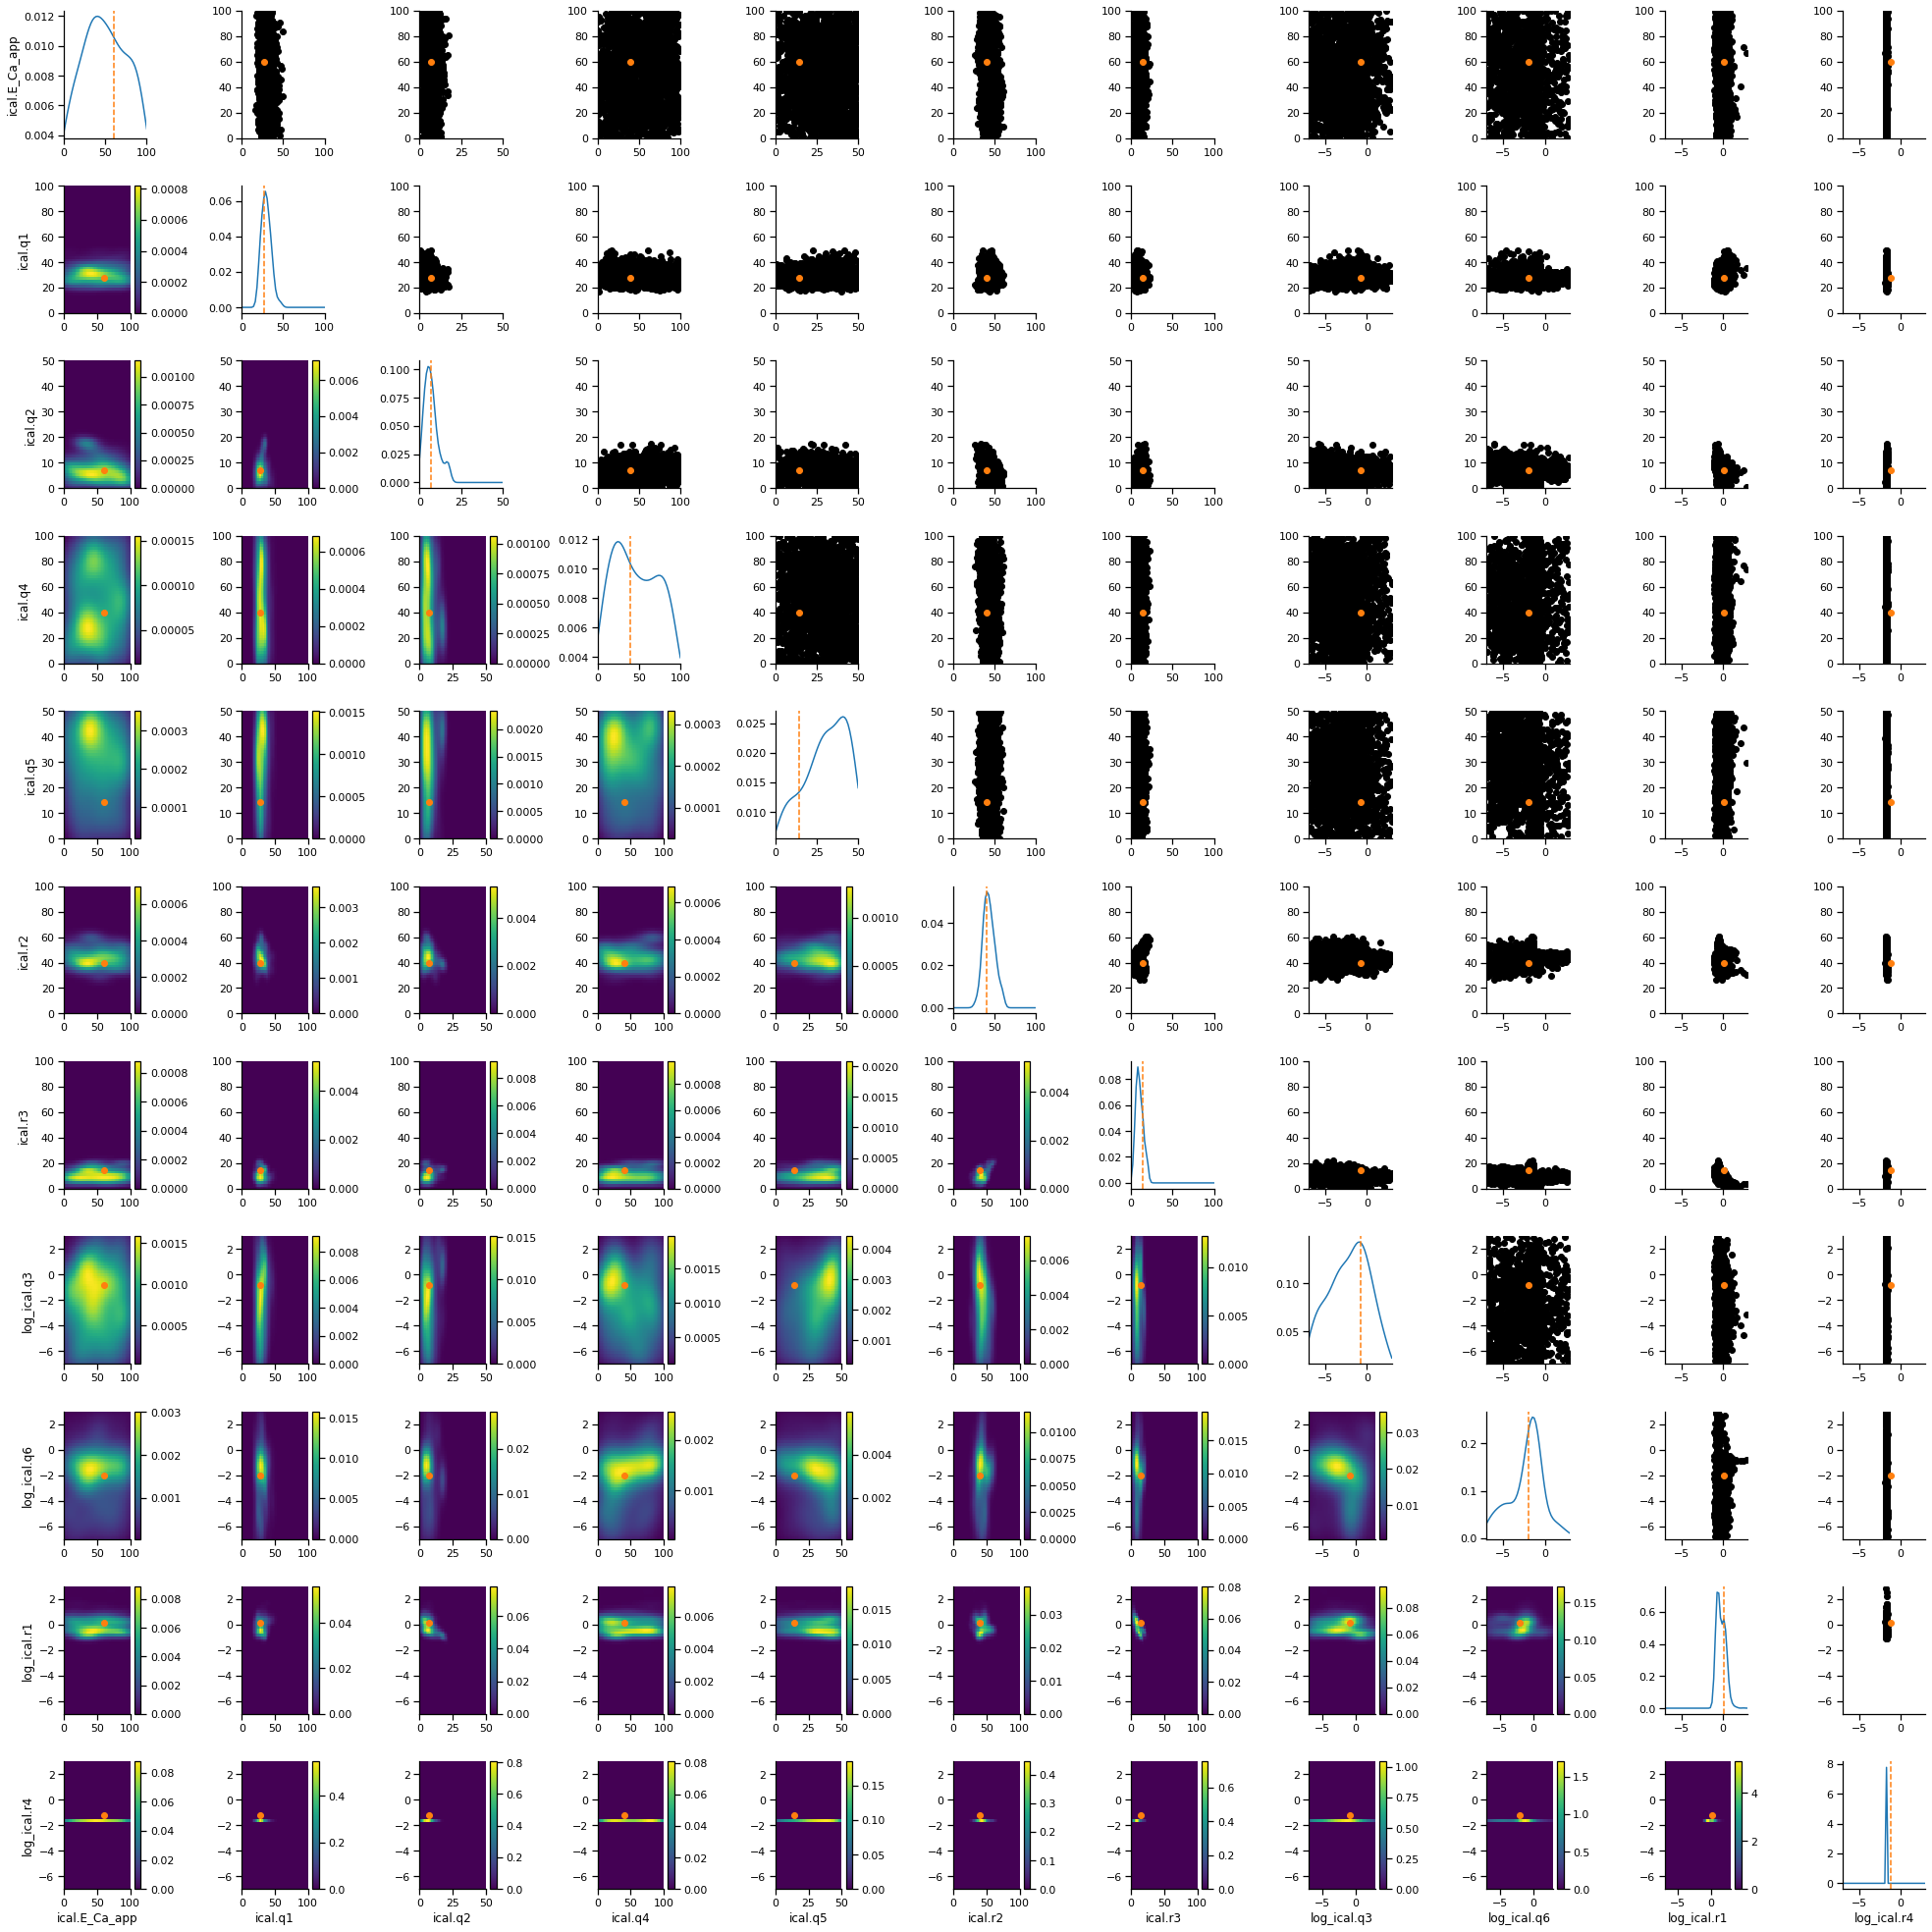

In [54]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [55]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

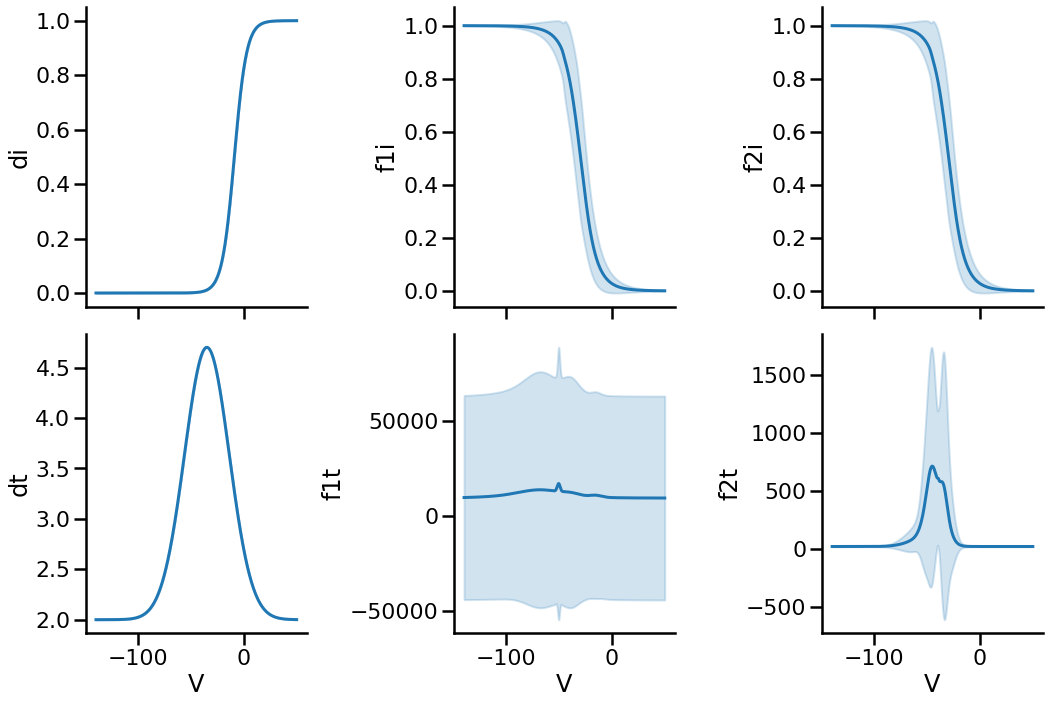

In [56]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_ical.mmt', 
                       [nyg_pars],
                       figshape=(3,2))